# 网站巡航全流程

## 1、导入包和数据

In [13]:
import pandas as pd
from pandas import DataFrame
import re
import math
import json
import jieba
from gensim import corpora,models,similarities
from sklearn.utils import shuffle as reset
import numpy
import matplotlib.pyplot as plt 
import random

In [4]:
with open("./沉积学黑白名单/专题/Detrital component.json",'rb') as load_f:
     load_dict = json.load(load_f)
data1 = load_dict['RECORDS']
with open("./沉积学黑白名单/专题/Modern fluvial deposit.json",'rb') as load_f:
     load_dict = json.load(load_f)
data2 = load_dict['RECORDS']
with open("./沉积学黑白名单/专题/Zircon.json",'rb') as load_f:
     load_dict = json.load(load_f)
data3 = load_dict['RECORDS']
data = data1+data2+data3
print(len(data1),len(data2),len(data3),len(data))

2261 11240 1803 15304


In [50]:
with open("./沉积学黑白名单/google_search_py_cj.json",'rb') as load_f:
     load_dict = json.load(load_f)
data = load_dict['RECORDS']
for i in data:
    i['subject']='Sedimentology'
len(data)

152420

In [5]:
df_white = pd.read_excel('./域名白名单汇总.xlsx',usecols=['dn'])
df_black = pd.read_excel('./域名黑名单汇总.xlsx',usecols=['dn'])
whitednlist = df_white['dn'].values.tolist()
blackdnlist = df_black['dn'].values.tolist()

In [6]:
set1 = set(whitednlist)
set2 = set(blackdnlist)
set1.intersection(set2)

set()

## 2、网站筛选过滤

In [54]:
blackword = ['baidu','bilibili','sohu','weibo','sina','youtube','google','taobao','douban','youdao','baike','wiki','pedia','researchgate',
             'amazon','twitter','qq','tecent','patent','worldwidescience','zhuanli','163','rhhz','d-nb','zhihu','zhidao','csdn','jianshu',
             'baijiahao','zhuanlan','blog','statesurveys','github','bartoc','jstor','Cited by','被引用','数据库',' OR ','…',
             'doc','wenku','news','/article','.pdf','/paper','/chapter','/book','/publication','/detail','/abstract','/journal','/doc',
             '/news','news/','/blog','/downloads']
dndic,wdic,bdic,gdic,predbdic={},{},{},{},{}
urllist,whiteurllist,blackurllist,greyurllist,predblist=[],[],[],[],[]
whitesublist,predbsublist=[],[]
whitekeylist,predbkeylist=[],[]
blackurllist0=[] #测试用
datadic_test = {'url':[], 'title':[], 'desc':[]}
num = 0
num0 = 0
for i in data:
    #域名提取
    if i['url_path'] is not None:
        matchObj = i['url_path'].split(' › ')
        dn = matchObj[0]
    else:
        a = i['url'].split('/')
        if a[2]=='googleweblight.com':
             dn = a[5]
        else:
             dn = a[2]
    urllist.append(i['url'])
    if dn in dndic:
        dndic[dn].append(i['url'])
    else:
        dndic[dn]=[i['url']]
    #白色域名
    if dn in whitednlist:
        if re.search('.pdf', i['url'], re.I) is None and re.search('/downloads', i['url'], re.I) is None:
            whiteurllist.append(i['url'])
            whitesublist.append(i['subject'])
            whitekeylist.append(i['keyword'])
            if dn in wdic:
                wdic[dn].append(i['url'])
            else:
                wdic[dn]=[i['url']]
    #黑色域名
    elif dn in blackdnlist:
        blackurllist0.append(i['url'])
        blackurllist.append(i['url'])
        if dn in bdic:
            bdic[dn].append(i['url'])
        else:
            bdic[dn]=[i['url']]
    else:
    #可能是可用数据库的域名
        if ((re.search('data', dn, re.I) or re.search('/data', i['url'], re.I) or re.search('data/', i['url'], re.I) or re.search('dataset/', i['url'], re.I)) is not None):
            flag = 1
            for k in blackword:
                if (re.search(k, i['url'], re.I)) is not None:
                    flag = 0
                    break
            if flag and i['title'] is not None:
                datadic_test['url'].append(i['url'])
                datadic_test['title'].append(i['title'])
                datadic_test['desc'].append(i['desc'])
                predblist.append(i['url'])
                predbsublist.append(i['subject'])
                predbkeylist.append(i['keyword'])
                if dn in predbdic:
                    predbdic[dn].append(i['url'])
                else:
                    predbdic[dn]=[i['url']]
                continue
    #文献搜索库、文档库、新闻、论坛讨论、百科、其他等类型
        cnt = 0
        for j in blackword:
            cnt = cnt + 1
            if re.search(j, i['url'], re.I) is not None:
                blackurllist.append(i['url'])
                if dn in bdic:
                    bdic[dn].append(i['url'])
                else:
                    bdic[dn]=[i['url']]
                break
    #剩余模糊网站
        if cnt == len(blackword):
            greyurllist.append(i['url'])
            if dn in gdic:
                gdic[dn].append(i['url'])
            else:
                gdic[dn]=[i['url']]
#黑色、备选、灰色域名中有重复的，优先级从左到右

#b中重复的键值对向a合并
def move(a, b):
    temp = []
    for i in b:
        if i in a:
            a[i] = a[i] + b[i]
            temp.append(i)
    for i in range(len(temp)):
        b.pop(temp[i])

move(predbdic, gdic)
move(bdic, predbdic)
move(bdic, gdic)

print('总域名数：', len(dndic))
print('总网站数：', len(urllist))
print('白色域名数：', len(wdic))
print('白色网站数：', len(whiteurllist))
print('黑色域名数：', len(bdic))
print('黑色网站数：', len(blackurllist))
print('灰色域名数：', len(gdic))
print('灰色网站数：', len(greyurllist))
print('备选域名数：', len(predbdic))
print('备选网站数：', len(predblist))
print(len(whiteurllist)+len(blackurllist)+len(greyurllist)+len(predblist))
print(len(wdic)+len(bdic)+len(gdic)+len(predbdic))

总域名数： 33464
总网站数： 152420
白色域名数： 311
白色网站数： 8438
黑色域名数： 16673
黑色网站数： 88960
灰色域名数： 15356
灰色网站数： 51901
备选域名数： 1109
备选网站数： 2007
151306
33449


In [8]:
whitea = pd.DataFrame({'url':whiteurllist, 'subject':whitesublist,'keyword':whitekeylist})
len(whitea)
#writer = pd.ExcelWriter('./岩浆地球化学/白色网站.xlsx')
#whitea.to_excel(writer,index=None)
#writer.save()

1361

In [9]:
len(predblist)

263

#### 生成黑色网站

In [57]:
random.seed(10)
blackurllist0 = []
for i in blackurllist:
    if re.search('.pdf', i, re.I) is None and re.search('.txt', i, re.I) is None and re.search('/downloads', i, re.I) is None:
        blackurllist0.append(i)
len(blackurllist0)
blackdata = random.sample(blackurllist0, 8000)
blackdata = pd.DataFrame({'url':blackdata})
writer = pd.ExcelWriter('./黑色网站/沉积学.xlsx')
blackdata.to_excel(writer,index=None)
writer.save()

## 3、频次统计

In [42]:
def sort(dic):
    dncnt = {}
    for i in dic:
        dncnt[i] = len(dic[i])
    dncnt=sorted(dncnt.items(),key=lambda dncnt:dncnt[1],reverse=True)
    dncnt=dict(dncnt)
    return dncnt
sort(predbdic)

{'www.chemspider.com': 85,
 'www.chegg.com': 81,
 'foodb.ca': 80,
 'www.metabolomicsworkbench.org': 61,
 'cncontext.com': 41,
 'search.library.wisc.edu': 40,
 'www.kancloud.cn': 40,
 'www.reddit.com': 39,
 'pdxscholar.library.pdx.edu': 38,
 'glosbe.com': 34,
 'nutritiondata.self.com': 32,
 'openscholarship.wustl.edu': 32,
 'www.coursera.org': 31,
 'digitalrepository.unm.edu': 30,
 'm.lycoasia.com': 27,
 'www.jiansuoke.com': 27,
 'data.giss.nasa.gov': 27,
 'wattsupwiththat.com': 26,
 'www.cloudscientific.com': 26,
 'www.marketwatch.com': 26,
 'resourcewatch.org': 25,
 'machinelearningmastery.com': 24,
 'study.com': 24,
 'www.enzyme-database.org': 22,
 'nativehealthdatabase.net': 22,
 'qastack.cn': 22,
 'www.nbsdc.cn': 21,
 'opendata.swiss': 21,
 'catalog.northslopescience.org': 20,
 'dataone.org': 20,
 'data.cnki.net': 20,
 'halo-db.pa.op.dlr.de': 20,
 'data.yjton.com': 19,
 'www.data.ac.cn': 19,
 'pandoradata.earth': 18,
 'cannabisdatabase.ca': 18,
 'www.geeksforgeeks.org': 18,
 'www.w

## 4、文本分类器

In [9]:
from word2vec import words, test_words, y_train, y_test
from word2vec import drop_stopwords
from word2vec import vec_count

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\Jiaro\AppData\Local\Temp\jieba.cache
Loading model cost 0.822 seconds.
Prefix dict has been built successfully.


In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vec_count = CountVectorizer(analyzer='word', max_features=3000, lowercase=False)
vec_count.fit(words)
from sklearn.naive_bayes import MultinomialNB
classifier_count = MultinomialNB(alpha=0.001)
classifier_count.fit(vec_count.transform(words), y_train)
classifier_count.score(vec_count.transform(test_words), y_test)

0.8240946045824095

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec_tfidf = TfidfVectorizer(analyzer='word', max_features=3000, lowercase=False)
vec_tfidf.fit(words)
from sklearn.naive_bayes import MultinomialNB
classifier_tfidf = MultinomialNB(alpha=0.001)
classifier_tfidf.fit(vec_tfidf.transform(words), y_train)
classifier_tfidf.score(vec_tfidf.transform(test_words), y_test)

0.8215077605321508

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
logitmodel=LogisticRegression(C=0.123,solver='lbfgs',multi_class='multinomial')#定义回归模型
logitmodel.fit(vec_count.transform(words),y_train)#训练模型
logitmodel.score(vec_count.transform(test_words), y_test)

0.8656406498106755

In [43]:
data_test = pd.DataFrame(datadic_test)
data_test

,url,title,desc
0,https://spacedata.copernicus.eu/datasets,Search Datasets - CSCDA (Copernicus Space Comp...,Mapping for city planning at local scale. Temp...
1,https://iiasa.ac.at/models-and-data/harmonized...,Harmonized World Soil Database (HWSD) | IIASA ...,2021年9月10日 · Access this dataset and learn mor...
2,https://kinomatics.com/about/data-and-technology/,Data and Technology | Kinomatics,The project database is RHEL 6 standard MySQL ...
3,https://data.isric.org/geonetwork/srv/api/reco...,Harmonized World Soil Database (HWSD) - ISRIC ...,"Soil information, from the global to the local..."
4,https://data.nceas.ucsb.edu/view/doi%3A10.5063...,Knowledge Network for Biocomplexity. - KNB,2020年10月15日 · A global database of long-term c...
...,...,...,...
7592,https://heidata.uni-heidelberg.de/dataset.xhtm...,Iconography of Venus from the Middle Ages to M...,"Bender, K., 2018, ""Image Set: Iconography of V..."
7593,https://vision.middlebury.edu/stereo/data/,Middlebury Stereo Datasets,"2021年11月20日 · (Sawtooth, Venus, Bull, Poster, ..."
7594,https://portal.ga.gov.au/metadata/geochemistry...,Organic Geochemistry - Maceral Group - Maceral...,The vitrinite maceral group comprises the sub-...
7595,https://www.casp.org.uk/products/geological-co...,Geological Collections and Data - CASP,Organic geochemistry (e.g. Rock-Eval pyrolysis...


In [44]:
content1 = data_test.desc.values.tolist()
content2 = data_test.title.values.tolist()

content = []
for i in range(len(content1)):
    content.append(content1[i].strip()+content2[i])

content_S = []
for line in content:
    line = line.strip()
    line = re.sub(r'[^\w\s]','',line)
    current_seg = jieba.lcut(line)
    for i in range(current_seg.count(' ')):
        current_seg.remove(' ')
    for i in current_seg:
        if i == '\xa0':
            current_seg.remove(i)
    content_S.append(current_seg)

df_content=pd.DataFrame({'content_S':content_S})
stopwords=pd.read_csv("CNENstopwords.txt", index_col=False,sep='\t',quoting=3,names=['stopwords'],encoding='utf-8')
contents0 = df_content.content_S.values.tolist()
stopwords0 = stopwords.stopwords.values.tolist()
contents_clean,all_words = drop_stopwords(contents0,stopwords0)
df_content_test = pd.DataFrame({'contents_clean':contents_clean})
df_test_x = df_content_test['contents_clean'].values
df_test_words = []
for line_index in range(len(df_test_x)):
    try:
        df_test_words.append(' '.join(df_test_x[line_index]))
    except:
        print(line_index,word_index)
len(df_test_words)

7597

In [45]:
a = pd.DataFrame({'url':predblist,'AI_label':list(logitmodel.predict(vec_count.transform(df_test_words))),'subject':predbsublist,'keyword':predbkeylist})
url,sub,key=[],[],[]
for row in a.itertuples():
    if row[2]==1:
        url.append(row[1])
        sub.append(row[3])
        key.append(row[4])
len(url)

3297

In [46]:
a = pd.DataFrame({'url':url,'subject':sub,'keyword':key})
result = whitea.append(a)
result = result.drop_duplicates(subset=['url'],keep='first')
print(len(result))
writer = pd.ExcelWriter('./新增学科/表生地球化学/表生地球化学总筛选网站.xlsx')
result.to_excel(writer,index=None)
writer.save()

17244


## 用确定的数据网站作为测试集

In [79]:
datadic_test = {'url':[], 'title':[], 'desc':[], 'label':[]}
for i in data:
    if i['url'] in whiteurllist and i['title'] is not None:
        datadic_test['url'].append(i['url'])
        datadic_test['title'].append(i['title'])
        datadic_test['desc'].append(i['desc'])
        datadic_test['label'].append(1)
    elif i['url'] in blackurllist0 and i['title'] is not None:
        datadic_test['url'].append(i['url'])
        datadic_test['title'].append(i['title'])
        datadic_test['desc'].append(i['desc'])
        datadic_test['label'].append(0)
data_test = pd.DataFrame(datadic_test)
data_test

,url,title,desc,label
0,https://www.researchgate.net/publication/30816...,(PDF) Fluorite (U-Th)/He thermochronology - Re...,2016年9月16日 · A comprehensive dataset of FHe ag...,0
1,https://www.researchgate.net/publication/23708...,In-situ detrital zircon (U–Th)/He thermochrono...,Request PDF | In-situ detrital zircon (U–Th)/H...,0
2,https://www.cambridge.org/core/journals/geolog...,Timing of fluorite mineralization and exhumati...,2021年4月16日 · 2015). We also extend the thermoc...,1
3,https://www.mindat.org/reference.php?id=350679,"Yamada, K., Tagami, T. (2006) (U–Th)/He thermo...","... Leaflet/flyer, Map, Online Database, Other...",1
4,https://www.degruyter.com/document/doi/10.1515...,Diffusion of Noble Gases in Minerals - De Gruyter,On the basis of a large dataset of repeat bulk...,0
...,...,...,...,...
7569,https://www.semanticscholar.org/paper/Dataset-...,Dataset on concentration and enrichment factor...,2019年5月24日 · Enrichment factors of mean values...,0
7570,https://www.degruyter.com/document/doi/10.1515...,Automated Quantitative Rare Earth Elements Min...,2016年9月30日 · Using density information that is...,0
7571,https://www.researchgate.net/publication/27857...,(PDF) Rare earth elements in French stream wat...,2019年1月17日 · Rare earth elements in French str...,0
7572,https://data.mendeley.com/datasets/g6zmthh6w5,Significant contribution of seamounts to the o...,"2022年1月6日 · Cite this dataset. Deng, Yinan (20...",1


In [80]:
content1 = data_test.desc.values.tolist()
content2 = data_test.title.values.tolist()
label = data_test.label.values.tolist()
content = []
for i in range(len(content1)):
    content.append(content1[i].strip()+content2[i])

content_S = []
for line in content:
    line = line.strip()
    line = re.sub(r'[^\w\s]','',line)
    current_seg = jieba.lcut(line)
    for i in range(current_seg.count(' ')):
        current_seg.remove(' ')
    for i in current_seg:
        if i == '\xa0':
            current_seg.remove(i)
    content_S.append(current_seg)
df_content=pd.DataFrame({'content_S':content_S})
stopwords=pd.read_csv("CNENstopwords.txt", index_col=False,sep='\t',quoting=3,names=['stopwords'],encoding='utf-8')
contents0 = df_content.content_S.values.tolist()
stopwords0 = stopwords.stopwords.values.tolist()
contents_clean,all_words = drop_stopwords(contents0,stopwords0)
df_content_test = pd.DataFrame({'contents_clean':contents_clean,'label':label})
df_test_x = df_content_test['contents_clean'].values
df_test_y = df_content_test['label'].values
df_test_words = []
for line_index in range(len(df_test_x)):
    try:
        df_test_words.append(' '.join(df_test_x[line_index]))
    except:
        print(line_index,word_index)
df_test_words[0]

'2016 16 comprehensive dataset FHe ages measured samples ore deposits Erzgebirge GermanyCzech Republic PDF Fluorite UThHe thermochronology ResearchGate'

In [81]:
logitmodel.score(vec_count.transform(df_test_words), df_test_y)

0.7799049379456033

In [82]:
predicted = logitmodel.predict(vec_count.transform(df_test_words))

In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_test_y, predicted)

array([[2600,  334],
       [1333, 3307]], dtype=int64)

In [84]:
def acu_curve(y,prob):
    fpr,tpr,threshold = roc_curve(y,prob) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
 
    plt.show()

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
prob = logitmodel.predict_proba(vec_count.transform(df_test_words))[:,1]

<Figure size 432x288 with 0 Axes>

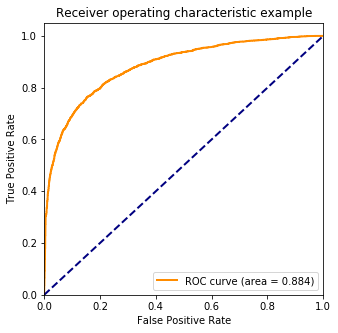

In [86]:
acu_curve(df_test_y, prob)